In [2]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fn, fn2
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [3]:
import matplotlib.pyplot as plt
import pickle

In [4]:
from implicit.als import AlternatingLeastSquares
from collections import defaultdict as ddict
from scipy.sparse import csr_matrix 
from implicit.nearest_neighbours import bm25_weight

In [5]:
cudaid = 2
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [6]:
torch.set_default_dtype(torch.float64)
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

## Defs of some fns

### Misc

In [6]:
def GenMissing(Yraw, OR=0.03, y1ratio=0.5):
    """
    OR: observed ratio.
    y1ratio: num of 1 / (num of 1 and 0) in the removed part
    """
    # get the R
    R = Yraw.clone()
    R[Yraw!=0] = 1

    rawOR = R.sum()/R.numel()
    assert OR <= rawOR
    
    numrv = R.numel() * (rawOR-OR) # number of samples to remove
    numrv1 = int(numrv*y1ratio) # number of 1 to remove
    numrv0 = int(numrv) - numrv1 # number of 0 to remove

    mask1 = (Yraw > 4.5) & (R==1) # matrix with observed 1 as True
    mask0 = (Yraw < 4.5) & (R==1) # matrix with observed 0 as True
    selidx1 = np.random.choice(int(torch.sum(mask1)), numrv1, replace=0)
    selidx0 = np.random.choice(int(torch.sum(mask0)), numrv0, replace=0)

    tmp1 = R[mask1] 
    tmp1[selidx1] = 0
    R[mask1] = tmp1

    tmp0 = R[mask0] 
    tmp0[selidx0] = 0
    R[mask0] = tmp0

    return R.double().to_sparse()


### Evaluations fns

In [7]:
# for MNAR
def RankMetric(res, R, Rtrain):
    betaX = torch.tensor(res["beta"])[flatX.long()] #  n x m
    eProbs = betaX + torch.tensor(res["bTheta"])
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

# for MNAR during iteration
def RankMetricIter(beta, bTheta, R, Rtrain):
    eProbs = beta[flatX.long()] + bTheta
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

# for WFS
def RankMetricALS(res, R, Rtrain):
    eProbs = torch.tensor(np.matmul(res.item_factors, res.user_factors.T))
    Rdiff = R.to_dense() - Rtrain.to_dense()
    eProbsQ = eProbs.argsort(axis=1, descending=True).argsort(axis=1)/eProbs.shape[1]
    testProbsQ = eProbsQ[Rdiff==1]
    testYraw = Yraw.to_dense()[Rdiff==1]
    metric = torch.sum(testProbsQ * testYraw)/torch.sum(testYraw)
    return metric

## Load the data

In [7]:
datDir = Path("./MovieLens/")

In [8]:
with open(datDir/"mvR3flatX.pkl", "rb") as f:
    flatX = pickle.load(f)
with open(datDir/"mvR3Y.pkl", "rb") as f:
    Yraw = pickle.load(f)
with open(datDir/"mvR3R.pkl", "rb") as f:
    R = pickle.load(f)
with open(datDir/"mvR3Ps.pkl", "rb") as f:
    Ps = pickle.load(f)

In [9]:
flatX = flatX.cuda().int()
R = R.cuda().double()
Ps = Ps.cuda().double()
Yraw = Yraw.cuda()

## WFS tuning

In [20]:
numFcts = [1, 2, 4, 8, 16, 32, 64, 128]
K1s = [1.2, 1.4, 1.6, 1.8, 2.0]

In [21]:
ressALS = []
for K1 in tqdm(K1s, desc="Main loop"):
    resALS = ddict(list)
    for numFct in tqdm(numFcts):
        for i in range(10):
            # remove some data
            Rtrain = GenMissing(Yraw.to_dense(), 0.03, 0.65)
            Yn = Yraw.clone().to_dense()
            Yn[Rtrain.to_dense()==0] = 0
            
            # obtain data for training
            YtrainArr = csr_matrix(Yn.cpu().numpy())
            YtrainArr.data[YtrainArr.data < 1] = 0
            YtrainArr.eliminate_zeros()
            YtrainArr = bm25_weight(YtrainArr, B=0.75, K1=K1).tocsr()
            
            ALSmodel = AlternatingLeastSquares(numFct, use_gpu=False)
            ALSmodel.fit(YtrainArr, show_progress=False)
            
            res = RankMetricALS(ALSmodel, R, Rtrain)
            resALS[numFct].append(res.item())
    ressALS.append(resALS)

Main loop:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
ressMeans = []
ressVars = []

for resALS in ressALS:
    ressMean = []
    ressVar = []
    for numFct in numFcts:
        resMean = torch.tensor(resALS[numFct]).mean()
        resVar = torch.tensor(resALS[numFct]).var()
        ressMean.append(resMean.item())
        ressVar.append(resVar.item())
    ressMeans.append(ressMean)
    ressVars.append(ressVar)

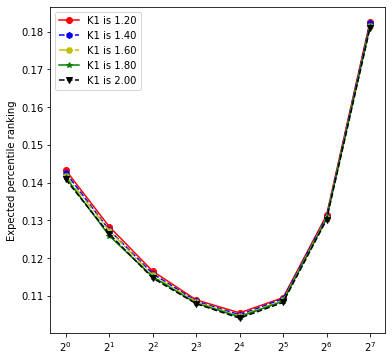

In [23]:
pchs = ["o-r", "h--b", "H-.y", "*-g", "v--k"]
plt.figure(figsize=[6, 6])
for idx in range(len(ressMeans)):
    ressMean = ressMeans[idx]
    plt.plot(numFcts, ressMean, pchs[idx], label=f"K1 is {K1s[idx]:.2f}")
#plt.text(optNumFct, minErr, f"The optimal num is {optNumFct}.")
plt.ylabel("Expected percentile ranking")
plt.xscale("log", base=2)
plt.legend()

In [24]:
ressMeans = np.array(ressMeans)
idxss = np.unravel_index(ressMeans.argmin(), ressMeans.shape)
optK1 = K1s[idxss[0]]
optNumFct = numFcts[idxss[1]]
print(f"Optimal K1 is {K1s[idxss[0]]}, "
      f"optimal num of facts is  {numFcts[idxss[1]]}, "
      f"optimal ranking is {ressMeans.min():.4f}.")

Optimal K1 is 2.0, optimal num of facts is  16, optimal ranking is 0.1041.


In [25]:
with open("./JMLRR3/MovieLensWCFTuning.pkl", "wb") as wf:
    pickle.dump(ressMeans, wf)

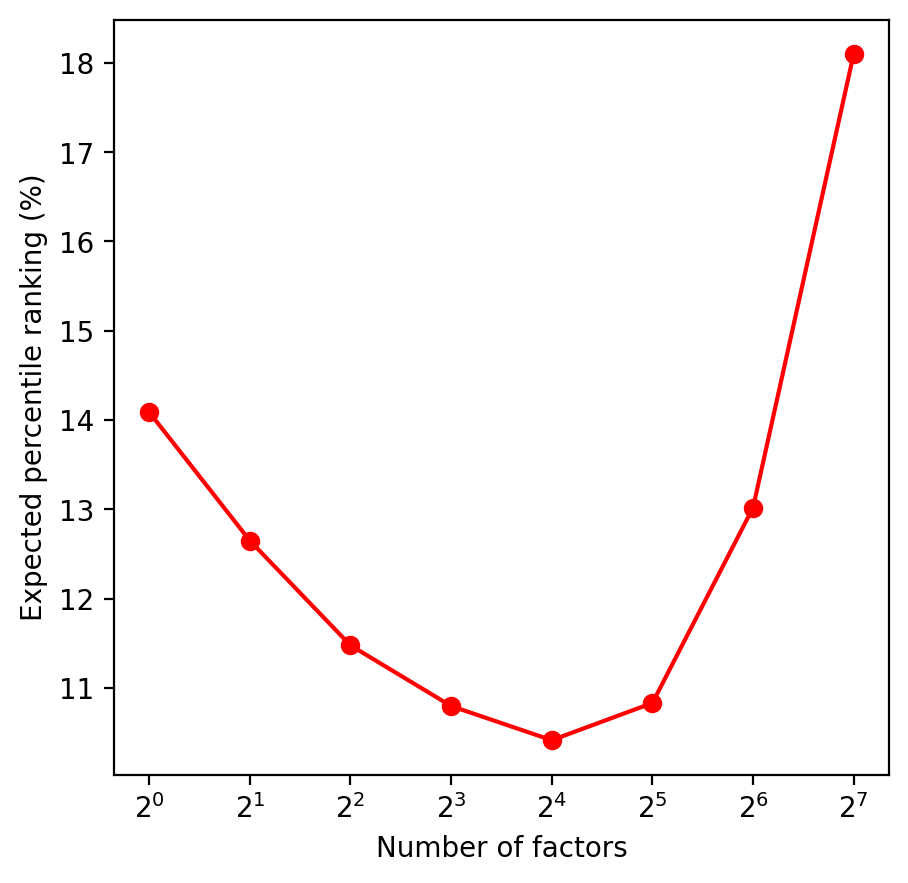

In [26]:
optMeans = ressMeans[idxss[0], :]
plt.figure(figsize=[5, 5], dpi=200)
plt.plot(numFcts, optMeans*100, "o-r")
plt.ylabel("Expected percentile ranking (%)")
plt.xlabel("Number of factors")
plt.xscale("log", base=2)
plt.savefig("./JMLRR3/MovieLensWCF.jpg", bbox_inches='tight')

## MNAR  related fns

### Some fns 

#### likelihood

In [11]:
sigmaY = 2
# the likelihood under normal 
def fnSim(y, m, sigma=sigmaY):
    # y     : n x m
    # m     : n x m 
    pi = torch.tensor([np.pi])
    prefix = torch.sqrt(1/pi/2/sigma**2)
    if y.dim() == m.dim():
        v = torch.exp(-(y-m)**2/2/sigma**2)
    else:
        v = torch.exp(-(y.unsqueeze(-1)-m)**2/2/sigma**2)
    return prefix*v

# first der of the likelihood under normal  with respect to the second part
def fnSim2(y, m,  sigma=sigmaY):
    pi = torch.tensor([np.pi])
    sigma2 = sigma**2
    prefix = torch.sqrt(1/pi/2/sigma2)
    if y.dim() == m.dim():
        return prefix*torch.exp(-(y-m)**2/2/sigma2)*(y-m)/sigma2
    else:
        return prefix*torch.exp(-(y.unsqueeze(-1)-m)**2/2/sigma2)*(y.unsqueeze(-1)-m)/sigma2

#### Integration

In [12]:
# this two fns are for integrations with classes
# int f(X) g(X) d X
def intCategory(beta, bThetaObs, Yobs, Ps, curf):
    msObs = bThetaObs.reshape(-1, 1) + beta # M x p 
    rawIntVs = curf(Yobs, msObs) # M x p
    intVs = (rawIntVs * Ps).sum(axis=-1) # M 
    #del msObs, rawIntVs
    #torch.cuda.empty_cache()
    return intVs

# int f(X) X g(X) d X
def intCategoryX(beta, bThetaObs, Yobs, Ps, curf):
    msObs = bThetaObs.reshape(-1, 1) + beta # M xp 
    rawIntVs = curf(Yobs, msObs) # M x p
    intVs = rawIntVs * Ps #M  xp
    #del msObs, rawIntVs
    #torch.cuda.empty_cache()
    return intVs

#### Fns for MAR

In [13]:
def marLpbCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            fnSim2: first dev of likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            First dev w.r.t beta, a vector of p
    """
    betaXobs = beta[flatXobs] # M 
    TbetaXobs = bThetaObs  + betaXobs # M 
    itm1Raw = fnSim2(Yobs, TbetaXobs)/(fnSim(Yobs, TbetaXobs)+seps) #M 
    itm1 = torch.zeros_like(beta) #p
    for ix in flatXobs.unique():
        itm1[ix] = itm1Raw[flatXobs==ix].sum()
        
    return -itm1/n/m

def marLpTCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            fnSim2: first dev of likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            First dev w.r.t bTheta, a vector of M 
    """
    betaXobs = beta[flatXobs]
    TbetaXobs = bThetaObs  + betaXobs
    itm1 = fnSim2(Yobs, TbetaXobs)/(fnSim(Yobs, TbetaXobs)+seps)
        
    itmObs = -itm1
    return itmObs/n/m

def marLCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            Value of loss function 
    """
    betaXobs = beta[flatXobs]
    TbetaXobs = bThetaObs  + betaXobs
    itm1 = fnSim(Yobs, TbetaXobs)
    res = - torch.log(itm1).sum()
    return res/n/m

#### Fn for MNAR

In [14]:
def LpbCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            fnSim2: first dev of likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            First dev w.r.t beta, a vector of p
    """
    betaXobs = beta[flatXobs] # M 
    TbetaXobs = bThetaObs  + betaXobs # M 
    itm1Raw = fnSim2(Yobs, TbetaXobs)/(fnSim(Yobs, TbetaXobs)+seps) #M 
    itm1 = torch.zeros_like(beta) #p
    for ix in flatXobs.unique():
        itm1[ix] = itm1Raw[flatXobs==ix].sum()
        
    itm2den=  intCategory(beta, bThetaObs, Yobs, Ps, fnSim)
    itm2int =  intCategoryX(beta, bThetaObs, Yobs, Ps, fnSim2)
    itm2 = itm2int/(itm2den.unsqueeze(-1)+seps)
    # del itm2int
    # torch.cuda.empty_cache()
    itm= (itm1 - itm2.sum(dim=0))
    return -itm

def LpTCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            fnSim2: first dev of likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            First dev w.r.t bTheta, a vector of M 
    """
    betaXobs = beta[flatXobs]
    TbetaXobs = bThetaObs  + betaXobs
    itm1 = fnSim2(Yobs, TbetaXobs)/(fnSim(Yobs, TbetaXobs)+seps)
        
    itm2den=  intCategory(beta, bThetaObs, Yobs, Ps, fnSim)
    itm2int =  intCategory(beta, bThetaObs, Yobs, Ps, fnSim2)
    itm2 = itm2int/(itm2den+seps)
    itmObs = -(itm1 - itm2)
    return itmObs

def LCategory(beta, bThetaObs, Yobs, flatXobs):
    """
        args:
            beta: covaraite parameters, a vector of p
            bThetaObs: theta parameters corresponding to observed value, a vector of M
            Yobs: observed Y, a vector of M
            flatXobs: the class of each item corresponding to observed value, a vector of M
            
        Some args in global env
            fnSim: likelihood function under normal
            Ps: The distribution of the items for each class, a vector of p, estimated from the X
        return:
            Value of loss function 
    """
    betaXobs = beta[flatXobs]
    TbetaXobs = bThetaObs  + betaXobs
    itm1 = fnSim(Yobs, TbetaXobs)
    itm2 =  intCategory(beta, bThetaObs, Yobs, Ps, fnSim)
    res = - (torch.log(itm1) - torch.log(itm2)).sum()
    return res

In [15]:
def LCategoryPart(beta, bThetaObs, Yobs, flatXobs, fct=10):
    """
        Run LCategory in fct times, to reduce the memory.
        args:
            fct: Num of parts to integration
    """
    n, m = R.shape
    M = Yobs.shape[0]
    lenSeg = int(np.ceil(M/fct))
    res = 0
    for ix in np.arange(0, M, lenSeg):
        lower, upper = ix, ix+lenSeg
        YobsP = Yobs[lower:upper]
        bThetaObsP = bThetaObs[lower:upper]
        flatXobsP = flatXobs[lower:upper]
        res += LCategory(beta, bThetaObsP, YobsP, flatXobsP)
    return res/m/n

def LpbCategoryPart(beta, bThetaObs, Yobs, flatXobs, fct=10):
    """
        Run LpbCategory in fct times, to reduce the memory.
        args:
            fct: Num of parts to integration
    """
    n, m = R.shape
    M = Yobs.shape[0]
    lenSeg = int(np.ceil(M/fct))
    res = 0
    for ix in np.arange(0, M, lenSeg):
        lower, upper = ix, ix+lenSeg
        YobsP = Yobs[lower:upper]
        bThetaObsP = bThetaObs[lower:upper]
        flatXobsP = flatXobs[lower:upper]
        res += LpbCategory(beta, bThetaObsP, YobsP, flatXobsP)
    return res/m/n

def LpTCategoryPart(beta, bThetaObs, Yobs, flatXobs, fct=10):
    """
        Run LpTCategory in fct times, to reduce the memory.
        args:
            fct: Num of parts to integration
      """
    n, m = R.shape
    M = Yobs.shape[0]
    lenSeg = int(np.ceil(M/fct))
    res = torch.zeros(M)
    for ix in np.arange(0, M, lenSeg):
        lower, upper = ix, ix+lenSeg
        YobsP = Yobs[lower:upper]
        bThetaObsP = bThetaObs[lower:upper]
        flatXobsP = flatXobs[lower:upper]
        resP = LpTCategory(beta, bThetaObsP, YobsP, flatXobsP)
        res[lower:upper] = resP
    return res/n/m
    

### Loop

In [16]:
from pynvml.smi import nvidia_smi
nvsmi = nvidia_smi.getInstance()
nvsmi.DeviceQuery('memory.free, memory.total')["gpu"]

[{'fb_memory_usage': {'total': 32475.1875, 'free': 32346.75, 'unit': 'MiB'}},
 {'fb_memory_usage': {'total': 32478.1875, 'free': 32465.9375, 'unit': 'MiB'}},
 {'fb_memory_usage': {'total': 32478.1875, 'free': 26967.9375, 'unit': 'MiB'}},
 {'fb_memory_usage': {'total': 32478.1875, 'free': 32465.9375, 'unit': 'MiB'}}]

#### Loop Fn of MAR

In [17]:
def marfRun(Rtrain, CT, Cb, etaT, etab, is_plot=False, is_showPro=False, is_res=False):
    Yobs = Yraw.to_dense()[Rtrain.to_dense().bool()]
    flatXobs = flatX[Rtrain.to_dense().bool()].long()
    
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    bThetaOldObs = bThetaOld[Rtrain.to_dense()==1]
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaNorms = []
    bThetaNorms = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        if is_res:
            res = RankMetricIter(betaOld, bThetaOld, Rall, Rtrain)
            print(res)
        t0 = time.time()
        curGPU0 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        LvNow = marLCategory(betaOld, bThetaOldObs, Yobs, flatXobs)
        
        t1 = time.time()
        curGPU1 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        # update beta
        LpbvOld = marLpbCategory(betaOld, bThetaOldObs, Yobs, flatXobs)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = betaNewRaw.clone()
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        curGPU2 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        LpTvOldObs = marLpTCategory(betaNew, bThetaOldObs, Yobs, flatXobs)
        LpTvOld = torch.zeros((n, m))
        LpTvOld[Rtrain.to_dense().bool()] = LpTvOldObs
        #print(LpTvOld.norm(), betaNewRaw, betaNew)
       
        t3 = time.time()
        curGPU3 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=40) # it can be very  fast
        U, S, V =  svdres
        #bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        curGPU4 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts))
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
        #print([curGPU0, curGPU1, curGPU2, curGPU3, curGPU4])
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        bThetaNorms.append(bThetaNew.norm().item())
        betaNorms.append(betaNew.norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        #bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        bThetaOldObs = bThetaOld[Rtrain.to_dense()==1]
        etaT = etaT * 0.99
        etab = etab * 0.99
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Theta Norm")
            plt.plot(list(range(0, t+1)), bThetaNorms)
            plt.scatter(t, bThetaNorms[-1], color="red", s=20)
            plt.text(t, bThetaNorms[-1], f"Theta norm is {bThetaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("beta norm")
            plt.plot(list(range(0, t+1)), betaNorms)
            plt.scatter(t, betaNorms[-1], color="red", s=20)
            plt.text(t, betaNorms[-1], f"Beta norm is {betaNorms[-1]:.3f}")
            
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

#### Loop fn for MNAR

In [18]:
def fRun(Rtrain, CT, Cb, etaT, etab, is_plot=False, is_showPro=False, is_res=False):
    Yobs = Yraw.to_dense()[Rtrain.to_dense().bool()]
    flatXobs = flatX[Rtrain.to_dense().bool()].long()
    
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    bThetaOldObs = bThetaOld[Rtrain.to_dense()==1]
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaNorms = []
    bThetaNorms = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        if is_res:
            res = RankMetricIter(betaOld, bThetaOld, Rall, Rtrain)
            print(res)
        t0 = time.time()
        curGPU0 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        LvNow = LCategoryPart(betaOld, bThetaOldObs, Yobs, flatXobs, fct=fct)
        
        t1 = time.time()
        curGPU1 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        # update beta
        LpbvOld = LpbCategoryPart(betaOld, bThetaOldObs, Yobs, flatXobs, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = betaNewRaw.clone()
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
       
        t2 = time.time()
        curGPU2 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        LpTvOldObs = LpTCategoryPart(betaNew, bThetaOldObs, Yobs, flatXobs, fct=fct)
        LpTvOld = torch.zeros((n, m))
        LpTvOld[Rtrain.to_dense().bool()] = LpTvOldObs
        #print(LpTvOld.norm(), betaNewRaw, betaNew)
       
        t3 = time.time()
        curGPU3 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=40) # it can be very  fast
        U, S, V =  svdres
        #bThetaNew = U[:, :nR].matmul(torch.diag(S[:nR])).matmul(V[:, :nR].t())
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, S, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        curGPU4 = nvsmi.DeviceQuery('memory.free, memory.total')["gpu"][2]["fb_memory_usage"]['free']
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts))
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
        #print([curGPU0, curGPU1, curGPU2, curGPU3, curGPU4])
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        bThetaNorms.append(bThetaNew.norm().item())
        betaNorms.append(betaNew.norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        bThetaOldObs = bThetaOld[Rtrain.to_dense()==1]
        etaT = etaT * 0.9
        etab = etab * 0.9
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 5])
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Theta Norm")
            plt.plot(list(range(0, t+1)), bThetaNorms)
            plt.scatter(t, bThetaNorms[-1], color="red", s=20)
            plt.text(t, bThetaNorms[-1], f"Theta norm is {bThetaNorms[-1]:.3f}")
            #plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("beta norm")
            plt.plot(list(range(0, t+1)), betaNorms)
            plt.scatter(t, betaNorms[-1], color="red", s=20)
            plt.text(t, betaNorms[-1], f"Beta norm is {betaNorms[-1]:.3f}")
            
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

#### Run

In [57]:
n, m = Yraw.shape
Yobs = Yraw.to_dense()[R.to_dense().bool()]
flatXobs = flatX[R.to_dense().bool()].long()
p = Ps.shape[0]
betainit = torch.zeros(p) 
bThetainit = torch.rand(n, m)
Rall = R
Rtrain = GenMissing(Yraw.to_dense(), 0.03, 0.65)

In [58]:
maxIter = 50 
tol, tolT, tolb =1e-8, 0, 0
marCT, marCb, marEtaT, marEtab = [5e-6, 5e2, 1e8, 5e3] #MAR
resMAR = marfRun(Rtrain, marCT, marCb, marEtaT, marEtab, is_plot=False, is_showPro=True, is_res=False)

RankMetric(resMAR, Rall, Rtrain)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0913)

In [ ]:
fct = 4
maxIter = 20 
tol, tolT, tolb =1e-8, 0, 0
CT, Cb, etaT, etab =  [2e-05, 1e5, 1e7, 3]
bThetainit = torch.tensor(resMAR['bTheta'])
betainit = torch.tensor(resMAR['beta'])
#betainit = torch.zeros(p) 
#bThetainit = torch.rand(n, m)
resMNAR = fRun(Rtrain, CT, Cb, etaT, etab, is_plot=False, is_showPro=True, is_res=True)

In [80]:
np.sum(resMNAR["beta"])

0.6453554462869824

## MNAR tuning

In [19]:
n, m = Yraw.shape
Yobs = Yraw.to_dense()[R.to_dense().bool()]
flatXobs = flatX[R.to_dense().bool()].long()
p = Ps.shape[0]
betainit = torch.zeros(p) 
bThetainit = torch.rand(n, m)
Rall = R
tol, tolT, tolb =1e-8, 0, 0
fct = 4

In [20]:
paraXs = [
[2e-05, 1e5, 1e7, 3],
[2e-05, 1e5, 2e7, 3],
[2e-05, 2e5, 1e7, 3],
[2e-05, 1e5, 1e7, 4],
[2e-05, 1e5, 1e6, 3],
[2e-05, 5e5, 1e7, 3]
]

In [21]:
resMNARss = []
resMARss = []
for paraX in tqdm(paraXs, desc="Main Loop"):
    CT, Cb, etaT, etab = paraX
    resMNARs = []
    resMARs = []
    for i in tqdm(range(100), desc="Inner Loop"):
        Rtrain = GenMissing(Yraw.to_dense(), 0.03, 0.65)
        
        betainit = torch.zeros(p) 
        bThetainit = torch.rand(n, m)
        try:
            marCT, marCb, marEtaT, marEtab = [5e-6, 5e2, 1e8, 5e3] #MAR
            maxIter = 50
            resMAR = marfRun(Rtrain, marCT, marCb, marEtaT, marEtab, is_plot=False, is_showPro=False, is_res=False)
            
            maxIter = 10
            bThetainit = torch.tensor(resMAR['bTheta'])
            betainit = torch.tensor(resMAR['beta'])
            resMNAR = fRun(Rtrain, CT, Cb, etaT, etab, is_plot=False, is_showPro=False, is_res=False)
        except: 
            pass
        else:
            resMNARs.append(RankMetric(resMNAR, R, Rtrain).item())
            resMARs.append(RankMetric(resMAR, R, Rtrain).item())
        if len(resMNARs) >= 10:
            break
    resMNARss.append((paraX, resMNARs, resMARs))

Main Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
resMs = [np.mean(resMNARs[1]) for resMNARs in resMNARss]
optX = resMNARss[np.argmin(resMs)][0]
print(f"The optimal parameters are {optX}, the ranking is {np.min(resMs):.4f}.")

The optimal parameters are [2e-05, 100000.0, 10000000.0, 4], the ranking is 0.0881.


## Compare MNAR with ALS

In [30]:
n, m = Yraw.shape
Yobs = Yraw.to_dense()[R.to_dense().bool()]
flatXobs = flatX[R.to_dense().bool()].long()
p = Ps.shape[0]
betainit = torch.zeros(p) 
bThetainit = torch.rand(n, m)
Rall = R
tol, tolT, tolb =1e-8, 0, 0
fct = 4

In [31]:
# opt parameters  by tuning 
optNumFct = 16
optK1 = 2
CT, Cb, etaT, etab = [2e-05, 100000.0, 10000000.0, 4]

In [32]:
resRanks = []
for i in tqdm(range(20), desc="Loop"):
    Rtrain = GenMissing(Yraw.to_dense(), 0.03, 0.65)
    Yn = Yraw.clone().to_dense()
    Yn[Rtrain.to_dense()==0] = 0
    
    # obtain data for training
    YtrainArr = csr_matrix(Yn.cpu().numpy())
    YtrainArr.data[YtrainArr.data < 1] = 0
    YtrainArr.eliminate_zeros()
    YtrainArr = bm25_weight(YtrainArr, B=0.75, K1=optK1).tocsr()
    
    ALSmodel = AlternatingLeastSquares(optNumFct, use_gpu=False)
    ALSmodel.fit(YtrainArr, show_progress=False)
    
    resALSrank = RankMetricALS(ALSmodel, R, Rtrain).item()
    
    betainit = torch.zeros(p) 
    bThetainit = torch.rand(n, m)
    try:
        marCT, marCb, marEtaT, marEtab = [5e-6, 5e2, 1e8, 5e3] #MAR
        maxIter = 50
        resMAR = marfRun(Rtrain, marCT, marCb, marEtaT, marEtab, is_plot=False, is_showPro=False, is_res=False)
            
        maxIter = 10
        bThetainit = torch.tensor(resMAR['bTheta'])
        betainit = torch.tensor(resMAR['beta'])
        resMNAR = fRun(Rtrain, CT, Cb, etaT, etab, is_plot=False, is_showPro=False, is_res=False)
    except: 
        pass
    else:
        resMNARrank = RankMetric(resMNAR, R, Rtrain).item()
        resRanks.append([resALSrank, resMNARrank])

Loop:   0%|          | 0/20 [00:00<?, ?it/s]

In [33]:
ms = np.mean(resRanks, axis=0)
stds = np.std(resRanks, axis=0)

In [34]:
ups = ms + 1.96*stds
lowers = ms - 1.96*stds

In [35]:
print(f"95% CI for ALS is ({lowers[0]:.4f}, {ups[0]:.4f}).")

95% CI for ALS is (0.1036, 0.1046).


In [36]:
print(f"95% CI for MNAR is ({lowers[1]:.4f}, {ups[1]:.4f}).")

95% CI for MNAR is (0.0879, 0.0884).


In [37]:
with open("./JMLRR3/MovieLensLargePRes.pkl", "wb") as wf:
    pickle.dump(resRanks, wf)

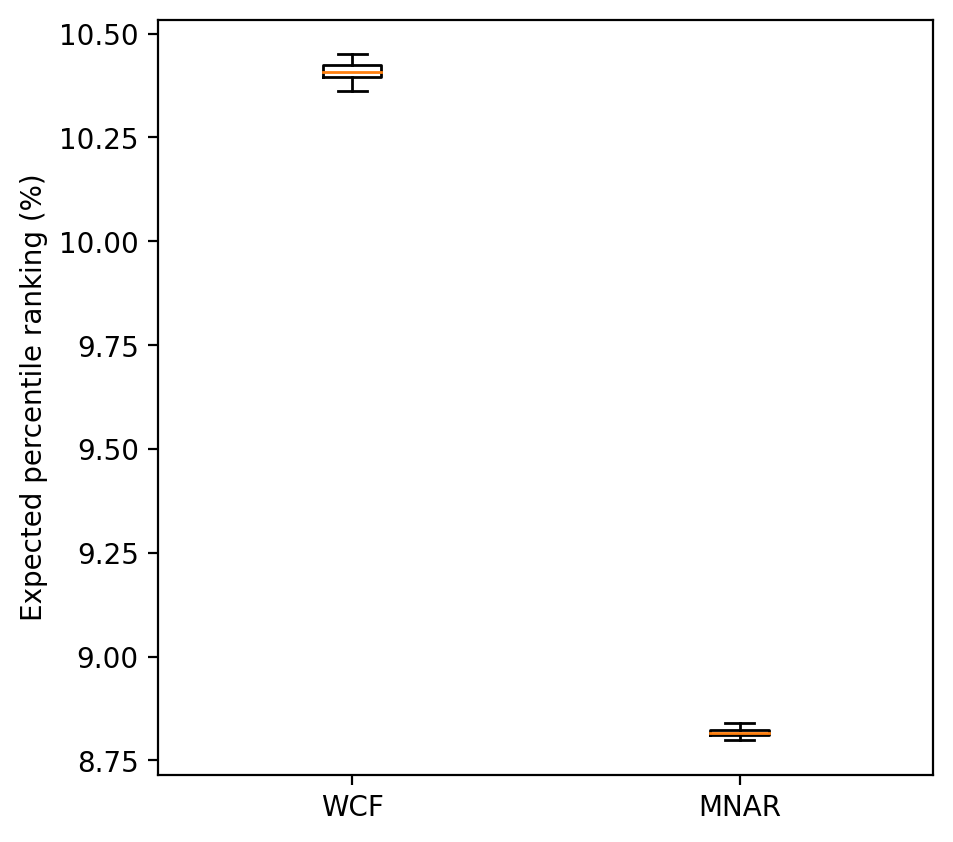

In [38]:
plt.figure(figsize=[5, 5], dpi=200)
plt.boxplot(np.array(resRanks)*100)
plt.ylabel("Expected percentile ranking (%)")
_ = plt.xticks([1, 2], ["WCF", "MNAR"])
plt.savefig("./JMLRR3/MovieLensLPBoxplot.jpg", bbox_inches='tight')